#

# Check TL and after unfreeze the compile seems let the model clear the wieght ?!

# 2021-12-26

# with current lrdrophold TL no imporve the val_acc. but InceptionV3 incress FTonly 0.878 to TLFT 0.879!!!

### Leaf benchmark for SOTA models and search better ensamble 

    2021-12-01
    This nb is adopt by KPTK_build_models_BaseModelsBuilder.ipynb and tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc_clean_GPUS-Temp-Leaf-EFN-2021-11-18-forReviewOnlyTwcc.ipynb
    
    (1) Rewrite tfds creation to read from CSV rather than from the name of directories. [12/03 done]
    (2)

12/08
VGG16/16 seems not works? train fail at step-2/epoch-1,


### -------------------------------------------------------------------------------- ###
<font color=#0000FF>*Cell Space*</font>

NOTE:<font color=#0000FF size=4> Markdown with color text </font> <br>
<p><font color="red">Red color</font></p>
<font color=#FF6600>橘色</font> <br>
<font color=#0000FF>***深藍色***</font> <br>

    縮排上下要空行https://github.com/ikatyang/emoji-cheat-sheet#flags
    
*斜體*<br>
**粗體**<br>
***粗斜體***<br>
___粗斜體___<br>
~~"刪除線"~~<br>
<u>底線<u> <br>


### -------------------------------------------------------------------------------- ###

### 1. ENV
#### <font color=#FF6600>[ENV] Turn off the error from twcc's AMP issue</font>

In [1]:
!export TF_ENABLE_AUTO_MIXED_PRECISION=0

#no work
!export TF_FORCE_GPU_ALLOW_GROWTH=1
# !export drop_remainder=False

# !export TF_ENABLE_AUTO_MIXED_PRECISION=1
# !export TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE=1



In [2]:
# !sh install_env.sh

#### <font color=#FF6600>[ENV] Moduls importing</font>

In [3]:
import os
# set log level should be before import tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["AUTOGRAPH_VERBOSITY"] = "0"

import cv2
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

import json
import errno
import seaborn as sns

from tqdm import tqdm
from cycler import cycler
from datetime import datetime

# albumentations
from functools import partial
import albumentations as A

# RandAugment, AutoAugment, augment.py from TF github
from augment import RandAugment,AutoAugment


from pytictoc import TicToc

t = TicToc() #create instance of class

t.tic() #Start time

In [4]:
print(f'tf: {tf.__version__} \ncv2: {cv2.__version__} \nnp: {np.__version__} \npd: {pd.__version__} \nmatplotlib: {matplotlib.__version__}')
t.toc()

tf: 2.5.0 
cv2: 4.5.3 
np: 1.19.5 
pd: 1.3.2 
matplotlib: 3.4.3
Elapsed time is 0.003962 seconds.


#### <font color=#FF6600>[ENV] Parameters</font>


In [5]:
# bench models
log_dir_name = "TrainSaveDir-1223-CDR_TLFT_WCD" # Put all results in same dir with different file name.
"""Ex: best_model_name: ./TrainSaveDir/ft_RRNET_imagenet1k_resize_120x120_CDCLR_AA_bs32_best_val_accuracy.h5"""


# hyper setting
weight="imagenet1k" #random, maybe just 1k is enough
crop= "crop" #"resize" #crop=center crop
lr_name= 'WCD' #'fixed' # 'CDR' #'WCD' #'plateau'#'lrdump' #"WCD" # WCD, WCDC, lrdump, platrure
augment= 'RA' #None # None, 'AA', 'RA', 'NoisyStudent', 'all'


# hyper models
top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss # for flood 0.2 is ok. for leaf 0.4 is better. for foot 0.8 is fine.
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 5 # classes of 5


# Image size
BATCH_SIZE = 4 #32#4 #2 # 8# 32 #64 #64:512*8 OOM, B7+bs8:RecvAsync is cancelled
img_height = 512 #600 #512 #120
img_width = 512 #600 #512 #120

patience_1 = 3
patience_2 = 5

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

# visible/logical device (able to be used)
print(tf.config.experimental.list_physical_devices('GPU'),'\n')
print(tf.config.experimental.list_logical_devices('GPU'),'\n')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num logical_gpus  :", len(tf.config.experimental.list_logical_devices('GPU')))

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')] 

[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU'), LogicalDevice(name='/device:GPU:4', device_type='GPU'), LogicalDevice(name='/device:GPU:5', device_type='GPU'), LogicalDevice(name='/device:GPU:6', device_type='GPU'), LogicalDevice(name='/device:GPU:7', device_type='GPU')] 

Num GPUs Available

### 2. Dataset (DS)

#### <font color=orange>[DS] Create the training dataset W/ croped</font>
#### <font color=#00FF00>[DS] Create the training dataset W/ croped</font>

    label_num_to_disease_map.json    {
    "0": "Cassava Bacterial Blight (CBB)", 
    "1": "Cassava Brown Streak Disease (CBSD)", 
    "2": "Cassava Green Mottle (CGM)", 
    "3": "Cassava Mosaic Disease (CMD)", 
    "4": "Healthy"}

In [6]:
CLASSES = ['CBB', 
           'CBSD', 
           'CGM', 
           'CMD', 
           'Healthy']
LABELS = {"0": "CBB", 
          "1": "CBSD", 
          "2": "CGM", 
          "3": "CMD", 
          "4": "Healthy"}

data_dir = '/home/u3148947/.keras/datasets/leaf/'
# leaf_dir = 'leaf/leaf_labels/'
leaf_dir = '/home/u3148947/.keras/datasets/leaf/train_images/'

df_train = pd.read_csv(data_dir + '/train.csv')


In [7]:
# check lables
for i in range(5):
    print(i, CLASSES[i])
print([(i,l) for i,l in zip(LABELS.keys(), LABELS.values())])

for i,l in zip(LABELS.keys(), LABELS.values()):
    print(i,l)

0 CBB
1 CBSD
2 CGM
3 CMD
4 Healthy
[('0', 'CBB'), ('1', 'CBSD'), ('2', 'CGM'), ('3', 'CMD'), ('4', 'Healthy')]
0 CBB
1 CBSD
2 CGM
3 CMD
4 Healthy


In [8]:
len(df_train)

21397

In [9]:
df_train[:5]

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [10]:
# Shuffle and reset index
# fixed shuffle for compare later, random_state=42
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df_train[:5]

,image_id,label
0,2615227158.jpg,4
1,1277648239.jpg,3
2,2305895487.jpg,3
3,336299725.jpg,2
4,1951270318.jpg,2


In [12]:
df_train.count()

image_id    21397
label       21397
dtype: int64

In [13]:
freq = df_train.groupby(['label']).count() 
print(freq)

       image_id
label          
0          1087
1          2189
2          2386
3         13158
4          2577


3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


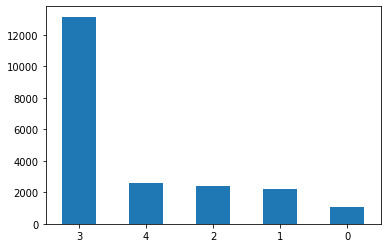

In [14]:
# get no key freq
freq = df_train['label'].value_counts() 
ax = freq.plot.bar(x='image_id', y='label', rot=0) #no key so x y no matter.
print(freq)

In [15]:
# check image size

import imageio
for tmp in ['827159844.jpg', '795383461.jpg', '851791464.jpg', '923880010.jpg']:
    tmp_img = imageio.imread(leaf_dir + '/' + tmp)
    print(type(tmp_img), tmp_img.shape, tmp_img.dtype)

<class 'imageio.core.util.Array'> (600, 800, 3) uint8
<class 'imageio.core.util.Array'> (600, 800, 3) uint8
<class 'imageio.core.util.Array'> (600, 800, 3) uint8
<class 'imageio.core.util.Array'> (600, 800, 3) uint8



#### <font color=#00FF00>[DS] Create tf.dataset (DS)</font>

In [16]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df_train['image_id'], df_train['label']))

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image_id, label = next(it_list_ds)
    print(image_id.numpy(), label.numpy())

b'2615227158.jpg' 4
b'1277648239.jpg' 3
b'2305895487.jpg' 3
b'336299725.jpg' 2


In [19]:
#
# map list to ds.
#
def process_path_label(image_id, label):
    file_path = leaf_dir + image_id
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = tf.io.decode_jpeg(img, channels=3)
    
    if crop == "resize":
        print("--resize")
        img = tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8) # for resize the training image for faster checing! tf.image.resize return a float!
    if crop == "crop":
        print("--crop")
        # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
        y1=(600-img_height)/2;    x1=(800-img_width)/2;    h=img_height;    w=img_width # not the pp location
        img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)

    return img, label

In [20]:
# Leaf train ds
train_ds_map = list_ds.map(process_path_label, num_parallel_calls=AUTOTUNE)

--crop


#### <font color=#00FF00>[DS] Split TVT</font>
train/val/test with ratio 7. 1.5 1.5

In [21]:
# split TVT train/val/test 7 1.5 1.5


val_size = int(tf.data.experimental.cardinality(train_ds_map).numpy() * 0.15)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

print("val size:", val_size)

train_ds_map_s = train_ds_map.skip(val_size+val_size)
temp_s = train_ds_map.take(val_size+val_size)

valid_ds_map_s = temp_s.take(val_size)
test_ds_map_s = temp_s.skip(val_size)

print("total size:", len(train_ds_map))
print("\ntrain", tf.data.experimental.cardinality(train_ds_map_s).numpy())
print("valid", tf.data.experimental.cardinality(valid_ds_map_s).numpy())
print("test", tf.data.experimental.cardinality(test_ds_map_s).numpy())


val size: 3209
total size: 21397

train 14979
valid 3209
test 3209


In [22]:
# # create iterator once
# iter_map = iter(train_ds_map_s)

In [23]:
# %%time
# # get new image every next time
# image, label = next(iter_map)

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.title(f'Image dtype: {image.dtype} and the range: {image.numpy().min()} to {image.numpy().max()}, shape:{image.shape}')

# print(f'Lable: {label}')

# """
# png
# Lable: 4
# CPU times: user 18.8 s, sys: 934 ms, total: 19.7 s
# Wall time: 36.6 s

# jpg
# Lable: 4
# CPU times: user 13.4 s, sys: 370 ms, total: 13.8 s
# Wall time: 3.57 s
# """

#### <font color=#00FF00>[DS] Augmentation and performance cache pipeline</font>

In [24]:
## AA, auto aug test

# image = tf.io.read_file(str(CMD[1]))
# image = tf.image.decode_jpeg(image, channels=3)

## RA, is upgraded version of AA.

def AA(image, label):
    Auto_Aug = AutoAugment()
#     auto_img = Auto_Aug.distort(image)
    return Auto_Aug.distort(image), label


def RA(image, label):
    Rand_Aug = RandAugment()
#     auto_img = Auto_Aug.distort(image)
    return Rand_Aug.distort(image), label


## DS performance cache

def configure_for_performance_cache(ds, cache=True, augment=None):  
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)

        
#     if augment== "Albu":
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)        
    if augment=="AA":
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    if augment=="RA":
        ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    if augment==None:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE, reshuffle_each_iteration=True) #buffer_size=MULTI_BATCH_SIZE*2 10sec. # (buffer_size=MULTI_BATCH_SIZE*5) ~10sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    """Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and 
        significant time to fill. Consider using Dataset.interleave across files if this becomes a problem."""
    
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds

In [25]:
# augment= #True#False #aug, AA, RA, ADA

train_ds_pre = configure_for_performance_cache(train_ds_map_s, cache=True, augment=augment)
valid_ds_pre = configure_for_performance_cache(valid_ds_map_s)
test_ds_pre = configure_for_performance_cache(test_ds_map_s)

Check cache in memory:Y True
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Check augment :Y RA
Check ds cache[True] and augment[RA]
Check cache in memory:Y True
Check augment :N None
Check ds cache[True] and augment[None]
Check cache in memory:Y True
Check augment :N None
Check ds cache[True] and augment[None]


AUTOTUNE= -1
batch * multi: 32
CPU times: user 23.6 s, sys: 1.82 s, total: 25.4 s
Wall time: 2.99 s


'\ntf.io.decode_png\nAUTOTUNE= -1\nbatch * multi: 64\nCPU times: user 9min 52s, sys: 23.5 s, total: 10min 15s\nWall time: 5min 10s\n\ntf.io.decode_jpeg\nAUTOTUNE= -1\nbatch * multi: 64\nCPU times: user 9min 40s, sys: 22.6 s, total: 10min 2s\nWall time: 3min 39s\n\n'

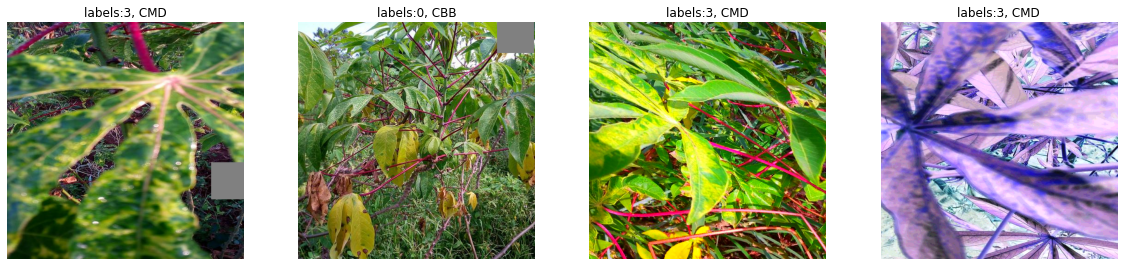

In [26]:
%%time

print('AUTOTUNE=', AUTOTUNE)

import math
col_row = math.sqrt(int(BATCH_SIZE))

plt.figure(figsize=(20, 20))
for images, labels in train_ds_pre.take(1):
    print('batch * multi:', len(labels))
    for i in range(4): # for batch size to show 4 32
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'labels:{labels[i]}, {CLASSES[labels[i]]}')
        plt.axis("off")
        
#why take so long
"""
tf.io.decode_png
AUTOTUNE= -1
batch * multi: 64
CPU times: user 9min 52s, sys: 23.5 s, total: 10min 15s
Wall time: 5min 10s

tf.io.decode_jpeg
AUTOTUNE= -1
batch * multi: 64
CPU times: user 9min 40s, sys: 22.6 s, total: 10min 2s
Wall time: 3min 39s

"""

In [27]:
# %%time
# print('AUTOTUNE=', AUTOTUNE)
# # too long

# #J 新版：tf2.3

# image_batch, label_batch = next(iter(train_ds_pre))
# plt.figure(figsize=(10, 10))
# plt.imshow(image_batch[1].numpy().astype("uint8"))
# # image_batch[1]

# print(f'Image dtype: {image_batch[1].dtype} and the range: {image_batch[1].numpy().min()} to {image_batch[1].numpy().max()}')

# """tf.cast(uint8) will hard fit source to 0-255"""

# """AUTOTUNE= -1
# Image dtype: <dtype: 'uint8'> and the range: 0 to 255
# CPU times: user 8min 56s, sys: 5.43 s, total: 9min 1s
# Wall time: 3min 28s

# AUTOTUNE= -1
# Image dtype: <dtype: 'uint8'> and the range: 0 to 255
# CPU times: user 8min 59s, sys: 5.81 s, total: 9min 5s
# Wall time: 3min 29s
# """

In [28]:
t.tic()

In [29]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre)

In [30]:
# %%time

# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
   
#     # 2021-11-05
#     # Check jpg, png agter ds is [0-255]
#     print(' [min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max()) 
    
#     print(f'Check lables: {label_batch[i]}')

# """CPU times: user 8min 54s, sys: 4.8 s, total: 8min 58s
# Wall time: 3min 27s

# CPU times: user 9min 2s, sys: 5.46 s, total: 9min 7s
# Wall time: 3min 30s

# ds.shuffle buffer_sizes  = MULTI_BATCH_SIZE
# CPU times: user 22 s, sys: 552 ms, total: 22.6 s
# Wall time: 7.75 s
# """

In [31]:
t.toc()

Elapsed time is 0.022518 seconds.


In [32]:
# %%time
# t.tic()
# num_bs=0
# for bs in tqdm(train_ds_pre):
# #     print(type(bs))
# #     print(".",end="")
# #     print(len(bs))
#     print([len(a) for a in bs])
#     num_bs += 1
# print("num_bs=", num_bs)
# t.toc()


"""跑完整個ds需要3min33s
100%|██████████| 235/235 [03:33<00:00,  1.10it/s]
num_bs= 235
Elapsed time is 213.461381 seconds.
CPU times: user 9min 1s, sys: 8.04 s, total: 9min 9s
Wall time: 3min 33s
"""

'跑完整個ds需要3min33s\n100%|██████████| 235/235 [03:33<00:00,  1.10it/s]\nnum_bs= 235\nElapsed time is 213.461381 seconds.\nCPU times: user 9min 1s, sys: 8.04 s, total: 9min 9s\nWall time: 3min 33s\n'

In [33]:
### 4. Models

### 4. Models

#### <font color="yellow"> [Models] </font>

In [34]:



"""
aps: module 'tensorflow.keras.applications' from '/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py
vim /usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py

可以實現由動態字串變數載入特定的基本模型<但是太多處理>還不如直接表列每項寫出來的清楚簡單!!!!

Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", 
"DenseNet121","DenseNet169","DenseNet201",
"NASNetMobile","NASNetLarge", 
"EfficientNetB0",
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7",
]
"""
import importlib 



    
def build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate):
    
    # move to Top 
    inputs = tf.keras.Input(shape=(img_height, img_width, 3)) #shape=(120, 120, 3), img_height, img_width shape=(img_height, img_width, 3)
    
    # EfficientNetB@# #
#     # OK efn
#     if model_name.startswith('EfficientNetB'):# == "EfficientNetB0":
#         root_m_name = 'efficientnet'
#         fullnameofmodel = "tensorflow.keras.applications." + root_m_name #model_name #model_name.lower()
#         model = importlib.import_module(fullnameofmodel)
#         BaseCnn = getattr(model,model_name)       
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}
    # shorter version of OK efn
    if model_name.startswith('EfficientNetB'):
        """For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer)."""
        BaseCnn = getattr(importlib.import_module("tensorflow.keras.applications.efficientnet"), model_name)       
        base_model = BaseCnn(include_top=False, weights="imagenet", drop_connect_rate=drop_connect_rate) #{'imagenet', None}
        # NO extra rescale need, efn already include the scaling inside the model
        rescaling_input = inputs
        
    # Xception #
    """When run in "tf" mode it actuallly expect the input to be uint8 between 0 and 255 and scales it to the range from -1.0 to 1.0. 
    Check the docstring and the source code.""" #NOT TRUE
    """ For Xception, call tf.keras.applications.xception.preprocess_input on your inputs before passing them to the model. 
    xception.preprocess_input will scale input pixels between -1 and 1."""
    if model_name.startswith('Xception'):
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.xception"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}
        
        rescaling_input = tf.keras.applications.xception.preprocess_input(inputs)

    # ResNet50 ResNet101 ResNet152 #
    if model_name.startswith('ResNet'):
        """For ResNet, call tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model. 
        resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with 
        respect to the ImageNet dataset, without scaling."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.resnet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.resnet.preprocess_input(inputs)
        
    # InceptionV3 #
    if model_name.startswith('InceptionV3'):
        """For InceptionV3, call tf.keras.applications.inception_v3.preprocess_input on your inputs before passing them to the model. 
        inception_v3.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.inception_v3"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)        

    # MobileNet #
    if model_name.endswith('MobileNet'):
        """ For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. 
        mobilenet.preprocess_input will scale input pixels between -1 and 1."""
        """
        The weight of trained (224, 224) will be load for fine turn, bcs the mbnet preteing size (). But it not matter in FT task.
        """
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet.preprocess_input(inputs)             
        
    # MobileNetV2 #
    if model_name.startswith('MobileNetV2'):
        """ For MobileNetV2, call tf.keras.applications.mobilenet_v2.preprocess_input on your inputs before passing them to the model. 
        mobilenet_v2.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet_v2"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)            
        
    # DenseNet121 DenseNet169 DenseNet201 #
    if model_name.startswith('DenseNet'):
        """ For DenseNet, call tf.keras.applications.densenet.preprocess_input on your inputs before passing them to the model."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.densenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.densenet.preprocess_input(inputs)            
        
    # NASNet: NASNetMobile #
    if model_name.startswith('NASNetMobile'):
        """For NASNet, call tf.keras.applications.nasnet.preprocess_input on your inputs before passing them to the model."""
        """Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
        for NASNetMobile It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (224, 224, 3) 
        would be one valid value. For loading imagenet weights, input_shape should be (224, 224, 3)"""
        
        """otherwise the input shape has to be (331, 331, 3) for NASNetLarge. It should have exactly 3 inputs channels, and width and height should 
        be no smaller than 32. E.g. (224, 224, 3) would be one valid value.  For loading imagenet weights, input_shape should be (331, 331, 3)"""
        """ NASNetMobile imagenet with 224: ted 10.x/5.x 
            NASNetMobile None with 120: ted 12.x/4.x,  seem no different at fine tune phase. """
        
        """pre-set use inputs = tf.keras.Input([None, None, 3]) to fake run build mode to get the model weight.  Then, run
        on normal build with specific input size without imagenet-weight, and reload the weight by hand.
        Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/nasnet/nasnet_mobile_no_top.h5
        Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-large-no-top.h5
        https://github.com/keras-team/keras-applications/issues/78
        """
        """Very large model, NASNetLarge take 8xM parameters, take 800~300 sec for one epoch.
        Epoch 00015: val_accuracy did not improve from 0.87036
        [306.6111526489258] of epoch 15
        CPU times: user 7h 30min 14s, sys: 32min 2s, total: 8h 2min 16s
        Wall time: 1h 26min 32s
        
        NASNetMobile: but loss: nan after epcoh 1, need reduce the lr!!!!!!!!!!!!!!!!!!!!!!!!!!!!!![12/14]Fixed by seprating mobile/large to two functions.
        Epoch 00011: val_accuracy did not improve from 0.64444
        [124.91568398475647] of epoch 11
        CPU times: user 3h 19min 49s, sys: 3min 41s, total: 3h 23min 31s
        Wall time: 29min 27s
        """
        # Pre download the model first for it weight later we need to reload it.
#         inputs = tf.keras.Input([None, None, 3])

        rescaling_input = tf.keras.applications.nasnet.preprocess_input(inputs)     

        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.nasnet"), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
#         base_model = BaseCnn(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)) #{'imagenet', None} for set input to 120x120    
#         base_model = BaseCnn(include_top=False, weights='imagenet') #{'imagenet', None} for set input to 120x120    

        # load weight by hand.
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(img_height, img_width, 3))
        
        # forgote where got it@@
        #base_model.load_weights('/home/u3148947/.keras/models/nasnet_mobile_no_top.h5') # If no load_weights, model.fit will take very long long time for initial when into the epoch 1.
        
        #NASNet-mobile-no-top.h5 https://github.com/fchollet/deep-learning-models/releases/ #same as above, epoch 2 loss nan
        base_model.load_weights('/home/u3148947/.keras/models/NASNet-mobile-no-top.h5') # If no load_weights, model.fit will take very long long time for initial when into the epoch 1.
        
    
    
    
#         inputs = tf.keras.layers.Resizing(224, 224) # tf >= 2.6.0, but currnet TWCC newest 21.08 is tf=2.5.0
#         i = tf.compat.v1.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs)
#         x = tf.cast(i, tf.float32)


    # NASNet: NASNetLarge #
    if model_name.startswith('NASNetLarge'):
        rescaling_input = tf.keras.applications.nasnet.preprocess_input(inputs)     

        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.nasnet"), model_name)    
        
        # load weight by hand.
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(img_height, img_width, 3))
        base_model.load_weights('/home/u3148947/.keras/models/nasnet_large_no_top.h5')


        
    # VGG16 # work with tf21.08
    """VGG16 not train even with None or Imagenet. pooling= is not the factor"""
    if model_name.startswith('VGG16'):
        """For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg16"), model_name)     
        base_model = BaseCnn(include_top=False, weights='imagenet') #{'imagenet', None}
        
        rescaling_input = tf.keras.applications.vgg16.preprocess_input(inputs)  

    # VGG19 #
    if model_name.startswith('VGG19'):
        """For VGG19, call tf.keras.applications.vgg19.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
        
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg19"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.vgg19.preprocess_input(inputs)  
    
    
    
    
#     # ViT # tf.hub version [Waiting for twcc update CCS image for version 21.11]
#     if model_name.startswith('ViT'):
#         """Inputs to the model must:
#             1.be four dimensional Tensors of the shape (batch_size, height, width, num_channels). Note that the model expects images with channels_last property. num_channels must be 3.
#             2.be resized to 224x224 resolution.
#             3.have pixel values in the range [-1, 1].
#         """
#         """ValueError: Unknown SavedObject type: None
#         but work in wth tf2.6.0, tf2.7.0

#         """
#         if model_name.startswith('ViT_b8'):
#             handle="https://tfhub.dev/sayakpaul/vit_b8_fe/1"
#         if model_name.startswith('ViT_s16'):
#             handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1"
#         num_classes=5
        
#         # ViT model as a layer
#         hub_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b8_fe/1", trainable=True)
#         model = tf.keras.Sequential([
#                                         inputs,
#                                         hub_layer,
#                                         keras.layers.Dense(num_classes, activation="softmax"),
#                                         ])

    # ViT # ViT-keras, but seems need more epoch to train.
    if model_name.startswith('ViT'):
        """For ViT (vit-keras)
        There are models pre-trained on imagenet21k for the following architectures: ViT-B/16, ViT-B/32, ViT-L/16, ViT-L/32 and ViT-H/14. 
        There are also the same models pre-trained on imagenet21k and fine-tuned on imagenet2012.
        
        pip install -U --quiet vit-keras # for imagenet21k pre-trained weight.
        pip install -U tensorflow-addons # for scratch
        """
        
        """base_model = vit.vit_b32
        Downloading data from https://github.com/faustomorales/vit-keras/releases/download/dl/ViT-B_32_imagenet21k+imagenet2012.npz
        
        base_model = vit.vit_b16
        Downloading data from https://github.com/faustomorales/vit-keras/releases/download/dl/ViT-B_16_imagenet21k+imagenet2012.npz
        """
        
        """
        ValueError: Input 0 of layer global_average_pooling2d is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 768)
        seems need use Flatten() to capture laster feature output.
        """
        """AssertionError: image_size must be a multiple of patch_size
        600 / 16 = 37.5
        512 / 16 = 32, only works
        """
        from vit_keras import vit
        #import tensorflow_addons as tfa
        
        #vit_b16 vit_b32  vit_L16 vit_L32  
        base_model = vit.vit_b16(
            image_size = img_width,
            activation = 'softmax',
            pretrained = True, #True,
            include_top = True,
            pretrained_top = False,
            classes = 5)




#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


    # ViT # tf.hub version [Waiting for twcc update CCS image for version 21.11]
    if model_name.startswith('ViT'):
        """ViT was loaded above already."""
        print(f'Set {model_name}')
        pass    
    
    elif model_name.startswith('ConvMixer'):
        """TEST"""
        print(f'Set {model_name}')
        pass  
        
    else:
        # Freeze the pretrained weights
        base_model.trainable = False #False #skip the TL so it shuld be change to True. and remove the free_model(). # True, for train TL+FT pipleline.
        print("base_model.trainable : ", base_model.trainable)
        print(f'Set others')

        # move to Top 
        # How to add training=False in base_model create
        #inputs = tf.keras.Input(shape=(120, 120, 3))
        #rescal = rescaling_input()(inputs)
        #b_m_output = base_model(inputs, training=False)

        b_m_output = base_model(rescaling_input, training=False)

        # Rebuild top
        gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
        #BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
        dropout = tf.keras.layers.Dropout(top_dropout_rate)(gap2d)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better. for foot 0.8 is fine.
        #outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help
        outputs = tf.keras.layers.Dense(outputnum, activation="softmax")(dropout)#todo: activation="softmax", default is "linear" activation: a(x) = x


        # Compile new model
        model = tf.keras.Model(inputs, outputs, name=model_name)

    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), #0.0001 1e-4 #RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])
    
    return model, base_model


# Pick a model #
Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", # 0-6 
"DenseNet121","DenseNet169","DenseNet201", # 7 8 9
"NASNetMobile","NASNetLarge", # 10 11 (hard code of size!224 331!)
"EfficientNetB0", #12
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7", #16
'VGG16', # 17 #at leass twcc21.11
'VGG19', # 18
'ViT_b8', #19 Vision Transformer
'ViT_s16',
'EANet',
'ConvMixer', #
'BiT', # BigTransfer
]

Model_List = Model_List[:19]
print(Model_List)

# model_name = Model_List[10]
# # print(Model_List[1:3])
# print(model_name)

# # Pick a model #
# Model_List = [#"MobileNet", "MobileNetV2", # 0-6 
# # "NASNetMobile",
#     "NASNetLarge",
# ]

model_name = Model_List[-1]
print(model_name)

['Xception', 'ResNet50', 'ResNet101', 'ResNet152', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'NASNetMobile', 'NASNetLarge', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB3', 'EfficientNetB5', 'EfficientNetB7', 'VGG16', 'VGG19']
VGG19


#### <font color="yellow"> [Models] Train misc. </font>

In [35]:
monitor = 'val_accuracy' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'



def get_best_model_name_bench():
#     return './' + log_dir_name + '/' + th + '_' + model_name + '_' + crop + "_" + str(img_width)+ '_bs' + str(BATCH_SIZE)  + '_best_' + monitor + '.h5'
    return f'./{log_dir_name}/{th}_{model_name}_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}.h5'


# weight="imagenet1k" #random
# crop= "resize" #cencrop :centercrop
# lr= "CDCLR" # WCD, platrure
# aug= "AA" # AA, RA, NoisyStudent, all


# th = 'toe'
# th = 'heel'

# th = "stage1"
th = "ft" # fine tune only without transfer learning.


In [36]:
# use once at the time
# log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir_name = "TrainSaveDir"

mk_log_dir(log_dir_name)

best_model_name = get_best_model_name(th)

best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

best_model_name: ./TrainSaveDir-1223-CDR_TLFT_WCD/ft_VGG19_bs4_w512_best_val_accuracy.h5


In [37]:
# model_name = "RRNET"
# img_width = img_height =120
# BATCH_SIZE = 32

# log_dir_name = "TrainSaveDir"

# best_model_name = get_best_model_name_bench(th)
# print('best_model_name:', best_model_name)

#### <font color="yellow"> [Models] Learning Rate Scheduler </font>

## WCD

In [38]:
# StepWise warmup cosine decay learning rate [optimazer]

# Reference:
# https://colab.research.google.com/github/sayakpaul/ViT-jax2tf/blob/main/fine_tune.ipynb
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2
# https://colab.research.google.com/github/google-research/vision_transformer/blob/linen/vit_jax.ipynb

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

    # 2021-12-19
    # If use optimizers.schedules.LearningRateSchedule and to save full model, need to rewrite the get_config()
    # https://stackoverflow.com/questions/61557024/notimplementederror-learning-rate-schedule-must-override-get-config
    def get_config(self):
        config = {
            'learning_rate_base':self.learning_rate_base,
            'total_steps':self.total_steps,
            'warmup_learning_rate':self.warmup_learning_rate,
            'warmup_steps':self.warmup_steps,
        }    
        return config


In [39]:
# train_ds_map_s: = all_train_img
# train_ds_pre: = all_train_img/batch

num_train = tf.data.experimental.cardinality(train_ds_map_s)
num_val = tf.data.experimental.cardinality(valid_ds_map_s)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 14979
Number of validation examples: 3209


In [40]:
EPOCHS = 20
EPOCHS_WARM = 10
TOTAL_STEPS = int((num_train / MULTI_BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = int((num_train / MULTI_BATCH_SIZE) * EPOCHS_WARM) #10 # warmup 2 epochs
INIT_LR = 0.004 #4e-3
WAMRUP_LR = 0.00001 #1e-5

print(f'total step/EPOCHS: {TOTAL_STEPS}/{EPOCHS}, MULTI_BATCH_SIZE:{MULTI_BATCH_SIZE}')

print(f'total step= (num_train / MULTI_BATCH_SIZE) * EPOCHS : {TOTAL_STEPS}=({num_train}/{MULTI_BATCH_SIZE})*{EPOCHS}')


total step/EPOCHS: 9361/20, MULTI_BATCH_SIZE:32
total step= (num_train / MULTI_BATCH_SIZE) * EPOCHS : 9361=(14979/32)*20


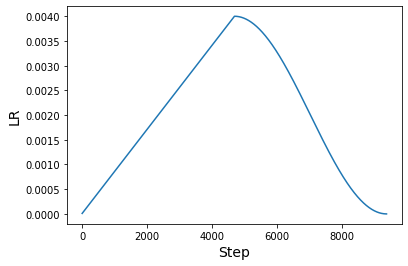

CPU times: user 4.66 s, sys: 318 ms, total: 4.98 s
Wall time: 4.3 s


In [41]:
%%time

WCD = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [WCD(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

CPU times: user 3.91 s, sys: 96.2 ms, total: 4 s
Wall time: 3.75 s


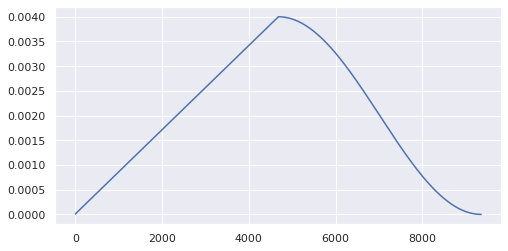

In [42]:
%%time

rng = [i for i in range(TOTAL_STEPS)]
y = [WCD(step) for step in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(rng, y)

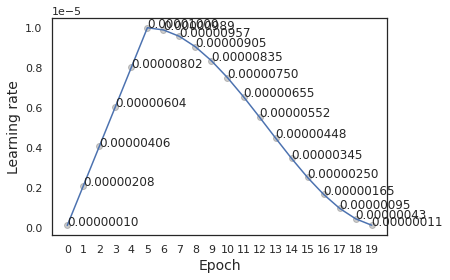

In [43]:
# treate step as epoch 

# need to reduce the lr, cause InceptionV3,
EPOCHS = 20
EPOCHS_WARM = 5

TOTAL_STEPS = EPOCHS
WARMUP_STEPS = EPOCHS_WARM

# INIT_LR = 0.001 #4e-3
# WAMRUP_LR = 0.00001 #1e-5

# for some models need very small lr.
INIT_LR = 0.00001 #1e-5
WAMRUP_LR = 0.0000001 #1e-7

WCD = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)



lrs = [WCD(step) for step in range(TOTAL_STEPS)]
y = lrs
x = [x for x in range(TOTAL_STEPS)]

sns.set(style='white') # will affect the further plot include plt or sns. 

plt.plot(x,lrs)
plt.xticks(x)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning rate", fontsize=14)

for a,b in zip(x, y): 
    #plt.text(a, b, str(b))
    plt.scatter(a,b, color='black', alpha=0.2)
    plt.annotate(f'{b:.8f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'


plt.show()

In [44]:
print('{} ~ {}'.format(min(y), max(y)))

1.0000000116860974e-07 ~ 9.999999747378752e-06


In [45]:
for i in y:
    print(i.numpy())

1e-07
2.08e-06
4.06e-06
6.04e-06
8.02e-06
1e-05
9.890738e-06
9.567727e-06
9.045085e-06
8.3456525e-06
7.5e-06
6.5450845e-06
5.522642e-06
4.4773574e-06
3.4549146e-06
2.4999997e-06
1.6543465e-06
9.549146e-07
4.3227254e-07
1.0926187e-07


In [46]:
# lr_list=[0.00001,
# 0.0002,
# 0.0004,
# 0.0006,
# 0.0008,
# 0.001,
# 0.000989,
# 0.000956,
# 0.000904,
# 0.000834,
# 0.00075,
# 0.000654,
# 0.000552,
# 0.00044,
# 0.00034,
# 0.00024,
# 0.00016,
# 0.0001,
# 0.00004,
# 0.00001,
# ]

# sns.set(style='white') # will affect the further plot include plt or sns. 

# x = [x for x in range(1, 21, 1)]

# plt.plot(x,lr_list)
# plt.xticks(x)

# plt.xlabel("Epoch", fontsize=14)
# plt.ylabel("Learning rate", fontsize=14)

# for a,b in zip(x, lr_list): 
#     #plt.text(a, b, str(b))
#     plt.scatter(a,b, color='black', alpha=0.2)
#     plt.annotate(f'{b:.8f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'


# plt.show()


In [47]:
# for i in range(20):
#     print(i, lr_list[i])
    

## CDR
#### warm Cosine Ddecay Rrestart

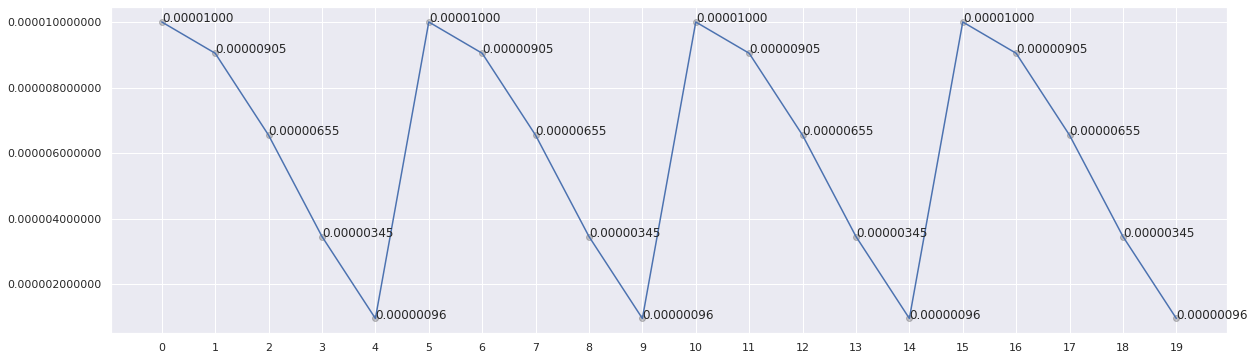

In [48]:
from matplotlib.ticker import FormatStrFormatter

ep_num = EPOCHS

initial_learning_rate = 1e-5
first_decay_steps = 5

CosineDecayCLRWarmUpLSW = tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1.0,
          m_mul=1.0,
          alpha = initial_learning_rate,
          name="CCosineDecayRestarts")

rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)
plt.xticks(rng)

for a,b in zip(rng, y): 
    #plt.text(a, b, str(b))
    plt.scatter(a,b, color='black', alpha=0.2)
    plt.annotate(f'{b:.8f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'

In [49]:
CDR = CosineDecayCLRWarmUpLSW

In [50]:
for i in range(20):
    print(i, y[i].numpy())

0 1e-05
1 9.045094e-06
2 6.545119e-06
3 3.4549796e-06
4 9.550051e-07
5 1e-05
6 9.045094e-06
7 6.5451195e-06
8 3.4549796e-06
9 9.55006e-07
10 1e-05
11 9.045094e-06
12 6.545118e-06
13 3.4549819e-06
14 9.55006e-07
15 1e-05
16 9.045094e-06
17 6.545118e-06
18 3.4549819e-06
19 9.55006e-07


#### fixed_WCD

In [51]:
def fixed_WCD(epoch):
    return lr_list[epoch]

#### lrdump

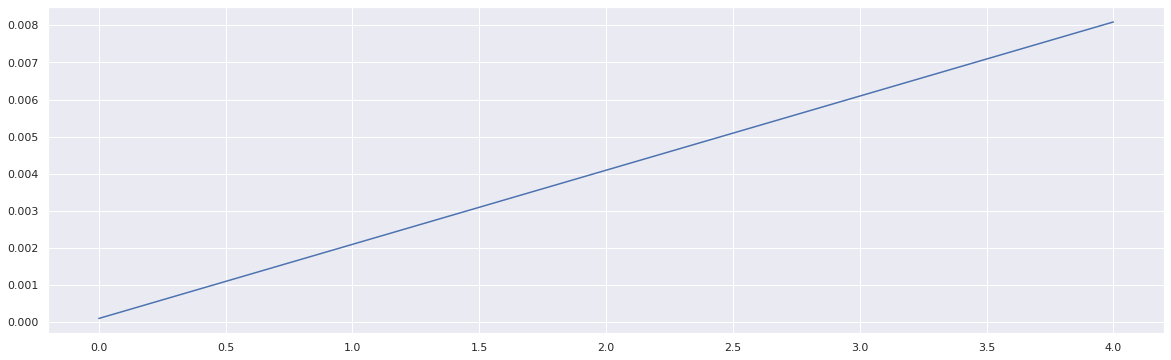

In [52]:
"""dump lr (Epochwise: callback)
"""
ep_num_transf = 5



def lrdump(epoch):
    
    #step_size = 100
#     lr_max = 0.004
#     lr_min = 0.00001
#     lr_start = 0.00001
    lr_max = 0.1
    lr_min = 0.001
    lr_start = 0.0001
    
    
    lr_init_ep = 0
    lr_ramp_ep = 50
    lr_sus_ep  = 0 #10
    lr_decay   = 0.95

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [53]:
print('{} ~ {}'.format(min(y), max(y)))

0.0001 ~ 0.008092


In [54]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.0001

1	 0.002098

2	 0.004096000000000001

3	 0.006094000000000001

4	 0.008092



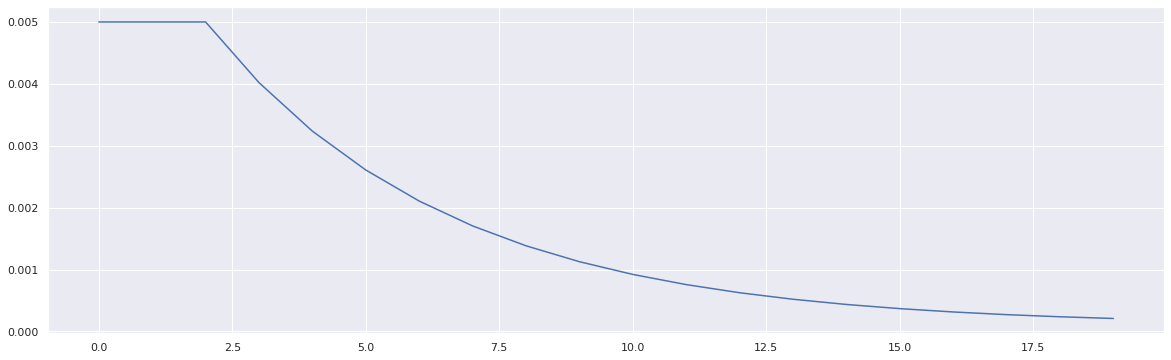

In [55]:
"""drop hold lr
"""


def lrdrophold(epoch):
    ep_num = 10

    step_size = 3
    lr_max = 0.005
    lr_min = 0.0001
    lr_start = 0.005

    lr_init_ep = 0
    lr_ramp_ep = 2
    lr_sus_ep  = 0
    lr_decay   = 0.8

    if lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num)]
y = [lrdrophold(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [56]:
print('{} ~ {}'.format(min(y), max(y)))

0.00021033819087057728 ~ 0.005


In [57]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.005

1	 0.005

2	 0.005

3	 0.00402

4	 0.003236

5	 0.0026088000000000005

6	 0.00210704

7	 0.0017056320000000003

8	 0.0013845056000000005

9	 0.0011276044800000004

10	 0.0009220835840000005

11	 0.0007576668672000003

12	 0.0006261334937600003

13	 0.0005209067950080002

14	 0.0004367254360064002

15	 0.00036938034880512014

16	 0.0003155042790440962

17	 0.00027240342323527696

18	 0.00023792273858822156

19	 0.00021033819087057728



In [58]:
def fixed_scheduler(epoch):
    return 0.0001 # 1e4
#     return 0.00001 # 1e5
#     return 0.000001 # 1e6

## Select LR_SCHEDULER

In [59]:
# Select LR_SCHEDULER [move inside the build_efn()]

if lr_name=='fixed':
    scheduled_lr = tf.keras.callbacks.LearningRateScheduler(fixed_scheduler)
    print(fixed_scheduler(1))
    
if lr_name=='lrdump':
    scheduled_lr = tf.keras.callbacks.LearningRateScheduler(lrdump)

if lr_name=='plateau':
    #learning_rate=0.0001 in the tf.keras.optimizers.Adam()
    scheduled_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor, factor=0.5, patience=1, verbose=1, 
        mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-8)
    
if lr_name=='WCD':
    # tk.optimizer
    scheduled_lr = tf.keras.callbacks.LearningRateScheduler(WCD)
    # tk.callback
#     scheduled_lr = tf.keras.callbacks.LearningRateScheduler(fixed_WCD)

if lr_name=='CDR':
    # tk.optimizer
    scheduled_lr = tf.keras.callbacks.LearningRateScheduler(CDR)
    

    
if lr_name=='WCDCR': # warmup cosin decay with cycle
    pass

print(f'Set scheduler LR : {lr_name}')

Set scheduler LR : WCD


#### <font color="yellow"> [Models] Callback </font>

In [60]:
# 2021-11-25 #
#TODO: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback 改寫為callbacks.on_epoch_begin(epoch) 並加入datetime方便在訓練時觀察時間
class PrintLR(tf.keras.callbacks.Callback):
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch=epoch
#         print(f"第 {epoch} 執行週期開始...")
#     def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))


#     def on_epoch_begin(self, epoch, logs=None):
#         print(f'[{datetime.now()}] Learning rate for epoch {epoch + 1} is {model.optimizer.lr.numpy()}')
        
    # time of epoch
    def on_train_begin(self,  epoch, logs=None):
        self.times = []
    def on_epoch_begin(self,  epoch, logs=None):
        self.epoch_time_start = time.time()
        #print(f'[{datetime.now()}] Learning rate for epoch {epoch + 1} is {model_toe.optimizer.lr.numpy()}') #for epochwise
        print(f'[{datetime.now()}] Learning rate for epoch {epoch + 1} is {self.model.optimizer._decayed_lr(tf.float32).numpy()}') #for stepwise
        
#         s_time = time.time()
#         print("start")

    def on_epoch_end(self,  epoch, logs=None):
        wall_time = time.time() - self.epoch_time_start
        self.times.append(wall_time)
        #print(f'[{self.times}] of epoch {epoch + 1}')
        print(f'[{wall_time}] of epoch {epoch + 1}')

        
callback_lr_time = PrintLR() #return a object of callback, not use the Classs PrintLR.

In [61]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_1), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     callback_lr_time
# #     tensorboard_callback,
# ]

#### <font color="yellow"> [Models] Build models </font>

In [62]:

# with strategy.scope():
#     # Model building/compiling need to be within `strategy.scope()`.
#     model_toe, base_model = build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate) # for efnet, Xincept


In [63]:
# len(model_toe.layers)

In [64]:
tt = 0
nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [65]:
# count_model_trainOrNot_layers(model_toe)

In [66]:
# base_model.summary()

In [67]:
# model_toe.summary()

#### <font color="yellow"> [Models] Train top layers (transfer learning)</font>

In [68]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre, 
#                       verbose=1, 
#                       epochs=5, #ep_num_transf, 
#                       validation_data=valid_ds_pre, 
#                       callbacks=callbacks)#, validation_split=0.1)

In [69]:
# EFntB7 
# inputs = 600*600, 8 gpu, bs4x8

# TL seems not work!


EFntB7 
inputs = 512*512, 8 gpu, bs32x8

Epoch 00012: val_accuracy improved from 0.73917 to 0.74478, saving model to ./TrainSaveDir/stage1_EfficientNetB7_bs32_w512_best_val_accuracy.h5
[40.45903658866882] of epoch 12
Epoch 13/500
[2021-12-07 13:03:08.241426] Learning rate for epoch 13 is 0.0009675999754108489
59/59 [==============================] - 39s 618ms/step - loss: 0.7936 - accuracy: 0.7024 - val_loss: 0.6922 - val_accuracy: 0.7445

Epoch 00013: val_accuracy did not improve from 0.74478
[38.982457876205444] of epoch 13
CPU times: user 1h 30min 59s, sys: 9min 19s, total: 1h 40min 19s
Wall time: 13min 11s

MBnetV2
DS, inputs = 512*512, 8 gpu, bs32x8

MBnetV2
DS, inputs = 512*512, 8 gpu, bs64x8


Epoch 00032: val_accuracy did not improve from 0.72608
[34.99274802207947] of epoch 32
CPU times: user 3h 1min 32s, sys: 8min 26s, total: 3h 9min 59s
Wall time: 21min

MBnetV2
DS, inputs = 120*120

Epoch 00016: val_accuracy did not improve from 0.68027
[11.85263991355896] of epoch 16
Epoch 17/500
235/235 [==============================] - 12s 44ms/step - loss: 1.1775 - accuracy: 0.6076 - val_loss: 0.9085 - val_accuracy: 0.6768


## 5. Fine tune

#### <font color="yellow"> [Models] Train bench models (Fine tune)</font>


In [70]:
def unfreeze_model(model, base_model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    # Set All layers trainable first
    #model.trainable = True #範例似乎是指 base_model.trainable = True 而不是新建model！！！！！！(2021-11-08)
    base_model.trainable = True
    
    
    
    # Then, set layers NOT trainable below specific layer.
#     set_trainable = False
#     for layer in model.layers:
#         if layer.name == 'block5b_expand_conv': 
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

"""NOTE THAT: if re-compile model again, the model seems will loss the weight it learned before!?"""

'NOTE THAT: if re-compile model again, the model seems will loss the weight it learned before!?'

In [71]:
# unfreeze for finetune the toe model  
# unfreeze_model(model_toe,base_model)

In [72]:
# count_model_trainOrNot_layers(model_toe)

In [73]:
# model_toe.summary()

In [74]:

# best_model_name_s2 = get_best_model_name(th)

# best_model_save_s2 = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name_s2, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name_s2:', best_model_name_s2)

In [75]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor=monitor, factor=0.1, patience=5, verbose=1, 
#     mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [76]:
# callbacks_s2 = [
# #     tensorboard_callback,
#     best_model_save_s2,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_2), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     callback_lr_time
# #     tensorboard_callback,
# ]

In [77]:
# %%time

# # fit the model on all data
# history_toe_finetune = model_toe.fit(train_ds_pre, 
#                       verbose=1, 
#                       epochs= 100,#ep_num_transf, 
#                       validation_data=valid_ds_pre, 
#                       callbacks=callbacks_s2)#, validation_split=0.1)

## <font color="yellow"> [Models] Train bench models (Fine tune)</font>

copy from K10L195

In [78]:
takenote=["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", # 0-6 
"DenseNet121","DenseNet169","DenseNet201", # 7 8 9
"NASNetMobile","NASNetLarge", # 10 11 (hard code of size!224 331!)
"EfficientNetB0", #12
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7", #16
'VGG16', # 17 #at leass twcc21.11
'VGG19', # 18
'ViT_b8', #19 Vision Transformer
'ViT_s16',
'EANet',
'ConvMixer', #
'BiT', # BigTransfer
]

In [79]:
# Model_List = takenote[:19]
Model_List

['Xception',
 'ResNet50',
 'ResNet101',
 'ResNet152',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'NASNetMobile',
 'NASNetLarge',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB3',
 'EfficientNetB5',
 'EfficientNetB7',
 'VGG16',
 'VGG19']

In [80]:
%%time


# use dict of dict to store hist
history_toe = []

# use dict of dict to store hist
history_toe_finetune = {}

# Model_List = ["Xception","MobileNet", 
# "EfficientNetB0", "NASNetMobile",
# ]

# Model_List = ["MobileNet", 
# "EfficientNetB0",
# ]

for model_name in Model_List:
    print("\n \n K = ", model_name, "\n")
    best_model_name = get_best_model_name_bench()
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_s1 = [
                #     tensorboard_callback,
                    best_model_save,
                    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_1), #patience=step_size or ep_num
                #     lr_reduceonplateau,
                    tf.keras.callbacks.LearningRateScheduler(lrdrophold),# lrdrophold, lrdump, decay or lrfn or lrfn2. clr
#                     scheduled_lr,
                    callback_lr_time,
                #     tensorboard_callback,
                ]
    
    callbacks_s2 = [
                #     tensorboard_callback,
                    best_model_save,
                    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_2), #patience=step_size or ep_num
                #     lr_reduceonplateau,
#                     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                    scheduled_lr,
                    callback_lr_time,
                #     tensorboard_callback,
                ]
    print('best_model_name:', best_model_name)


    with strategy.scope():
        model_toe, base_model = build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate)
    
    # Train K-Model with transfer learning # IF HAVE!
    
    # TL
    count_model_trainOrNot_layers(model_toe)
    print(model_toe.summary())
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre, 
                          verbose=1, 
                          epochs=5, 
                          validation_data=valid_ds_pre, 
                          callbacks=callbacks_s1)#, validation_split=0.1)
    history_toe.append(hist)
    
    
    # Train K-Model with fine tune #
    
    # bench models, FT
    unfreeze_model(model_toe,base_model) # skip the TL so unfreeze when build_EFN()
    count_model_trainOrNot_layers(model_toe)
    print(model_toe.summary())
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre, 
                          verbose=1, #'auto' or 0 1 2 , 0 = silent, 1 = progress bar, 2 = one line per epoch.
                          epochs=EPOCHS, 
                          validation_data=valid_ds_pre, 
                          callbacks=callbacks_s2)#, validation_split=0.1)
    # add the epoch timeing
    hist.history['epoch_time_secs'] = callback_lr_time.times
    history_toe_finetune[model_name] = hist.history #hist # what if use hist.history
    




 
 K =  Xception 

best_model_name: ./TrainSaveDir-1223-CDR_TLFT_WCD/ft_Xception_imagenet1k_crop_512x512_WCD_RA_bs32_best_val_accuracy.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduc

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


[91.8813157081604] of epoch 1
Epoch 2/5
[2021-12-26 17:35:56.388043] Learning rate for epoch 2 is 0.004999999888241291
469/469 [==============================] - 41s 84ms/step - loss: 0.8903 - accuracy: 0.6781 - val_loss: 0.7241 - val_accuracy: 0.7292

Epoch 00002: val_accuracy improved from 0.69523 to 0.72920, saving model to ./TrainSaveDir-1223-CDR_TLFT_WCD/ft_Xception_imagenet1k_crop_512x512_WCD_RA_bs32_best_val_accuracy.h5
[41.622742652893066] of epoch 2
Epoch 3/5
[2021-12-26 17:36:38.844699] Learning rate for epoch 3 is 0.004999999888241291
469/469 [==============================] - 50s 103ms/step - loss: 0.8885 - accuracy: 0.6812 - val_loss: 0.7585 - val_accuracy: 0.7177

Epoch 00003: val_accuracy did not improve from 0.72920
[50.35128951072693] of epoch 3
Epoch 4/5
[2021-12-26 17:37:29.997442] Learning rate for epoch 4 is 0.004019999876618385
469/469 [==============================] - 41s 84ms/step - loss: 0.8880 - accuracy: 0.6781 - val_loss: 0.7302 - val_accuracy: 0.7214

Epoc

KeyboardInterrupt: 

# MobileNetV2, NASNetMobile
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
  
  https://stackoverflow.com/questions/69590274/warning-custom-mask-layers-require-a-config-and-must-override-when-saving-the
  it was an issue with old versions (from TF2.5, TF2.6, and TF2.7).
  

In [81]:
# hist.history

In [82]:
# history_toe_finetune

In [83]:
# # hist is dict
# # but history_toe_finetune is a list of dict without the name

# history_toe_finetune['EfficientNetB0']['loss']
# # history_toe_finetune[:]

In [84]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in Model_List:
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k]['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:Xception
K:ResNet50
K:ResNet101
K:ResNet152
K:InceptionV3


KeyError: 'InceptionV3'

## <font color="yellow"> [Models] Result Ploting</font>

### Save hist to np

In [ ]:
# hist save to npy
# This bench log name
bench_log_name = f'./{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}.npy'
np.save(bench_log_name, history_toe_finetune)

# reload hist from npy
history_np_load = np.load(bench_log_name, allow_pickle='TRUE').item()
hisnp = history_np_load.copy()

# ploting train log


# ploting test acc %

### Reload np to hist

In [ ]:
# draft reload his from saved np
bench_log_name = f'./{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}.npy'

# Note that, if change bs4 to bs32, when load hist by one gpu container #
# bench_log_name = './TrainSaveDir-1223-CDR/ft_bench_imagenet1k_crop_512x512_CDR_RA_bs32_best_val_accuracy.npy'


# reload hist from npy
history_np_load = np.load(bench_log_name, allow_pickle='TRUE').item()
hisnp = history_np_load.copy()

In [ ]:
handles = [handle for handle in Model_List]
handles

In [ ]:
# ploting train log
plt.figure(figsize=(25, 10))

for k in Model_List:

    x = len(hisnp[k]['loss']) + 1
    x = range(1,x,1)
    y = hisnp[k]['loss']
    #y = [f'{z:.4f}' for z in y]
    plt.plot(x, y, label=f'{k}_loss')
    
    
    for a,b in zip(x, y): 
        #plt.text(a, b, str(b))
        plt.scatter(a,b, color='black', alpha=0.2)
        plt.annotate(f'{b:.3f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'
    
    y = hisnp[k]['val_loss']
    plt.plot(x, y, label=f'{k}_val_loss')

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(0, 2)# for too large loss
plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left')
# plt.show()

# plt.legend(['x','y'], title='models', loc='best')

# get handles
# handles = [handle for handle in Model_List]
# plt.legend(handles, title='Nets')

plt.legend(title='Nets')


# save plot : comment plo.show in jupyter notebook.  dpi=600 is good for journal.
dpi=300 # for quickly check
print(f'Save to {pgn} \n')
pgn=f'{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}_hisnpTL_loss.png'
plt.savefig(pgn, bbox_inches = 'tight', dpi=dpi)

In [ ]:
for k in Model_List:

    print(f"{k}: {hisnp[k]['val_accuracy']}")

In [ ]:
# ploting train log
plt.figure(figsize=(25, 10))

for k in Model_List:

    x = len(hisnp[k]['val_accuracy']) + 1
    x = range(1,x,1)
    y = hisnp[k]['val_accuracy']
    #y = [f'{z:.4f}' for z in y]
    plt.plot(x, y, label=f'{k}_val_accuracy')
    
    
    for a,b in zip(x, y): 
        #plt.text(a, b, str(b))
        plt.scatter(a,b, color='black', alpha=0.2)
        plt.annotate(f'{b:.3f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'
    
    #plt.plot(hisnp[k]['val_accuracy'])

    
plt.title('K-model-TL val_accuracy', fontsize='xx-large')
plt.ylabel('val_accuracy'), plt.ylim(0.1, 0.9)# for too large loss
plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left')
# plt.show()

# plt.legend(['x','y'], title='models', loc='best')

# get handles
# handles = [handle for handle in Model_List]
# plt.legend(handles, title='Nets')

plt.legend(title='Nets:', title_fontsize='x-large', fontsize='large')
"""title_fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}

"""

# save plot : comment plo.show in jupyter notebook.  dpi=600 is good for journal.
dpi=300
pgn= f'{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}_hisnpTL_val_acc.png'
print(f'Save to {pgn} \n')
plt.savefig(pgn, bbox_inches = 'tight', dpi=dpi)

In [ ]:
for k in Model_List:

    print(f"{k}: {hisnp[k]['val_accuracy']}")

In [ ]:
# hisnp

In [ ]:
# ploting train log with lr
# plt.figure(figsize=(25, 10))

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# ax1 for val_accuracy #
# nice to have this colorful tip.
color = 'tab:red'
ax1.set_title('K-model-TL val_accuracy with lr', fontsize='xx-large')
ax1.set_xlabel('epoch')
ax1.set_ylabel('val_accuracy', color=color)

for k in Model_List:

    x = len(hisnp[k]['val_accuracy']) + 1
    x = range(1,x,1)
    y = hisnp[k]['val_accuracy']
    #y = [f'{z:.4f}' for z in y]
    plt.plot(x, y, label=f'{k}_val_accuracy')
    
    
    for a,b in zip(x, y): 
        #plt.text(a, b, str(b))
        plt.scatter(a,b, color='black', alpha=0.2)
        plt.annotate(f'{b:.3f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'

ax1.tick_params(axis='y', labelcolor=color)    
ax1.legend(title='Nets:', title_fontsize='x-large', fontsize='large')
"""title_fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}"""


# ax2 for learning rate #
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('learning rate', color=color)
# ax2.plot(hisnp[k]['lr'], color=color)
x = len(hisnp[k]['lr']) + 1
x = range(1,x,1)
y = hisnp[k]['lr']
#y = [f'{z:.4f}' for z in y]
plt.plot(x, y, color='green', label=f'learning rate')

for a,b in zip(x, y): 
    #plt.text(a, b, str(b))
    plt.scatter(a,b, color='green', alpha=0.2)
    plt.annotate(f'{b:.7f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(fontsize='large', loc='upper center') 


        


# save plot : comment plo.show in jupyter notebook.  dpi=600 is good for journal.
dpi=300
pgn= f'{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}_hisnpTL_val_acc_lr.png'
print(f'Save to {pgn} \n')
plt.savefig(pgn, bbox_inches = 'tight', dpi=dpi)

### with cycle color/marker

In [ ]:
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams["markers.fillstyle"] = 'left' # 'full', 'left', 'right', 'bottom', 'top', 'none'


auto_custom_cycler_01 = (cycler(color=[plt.get_cmap('jet')(i/13) for i in range(24)]) + # 24 colors
                  cycler(linestyle=['-', '--', ':', '-.'] * 6) + # [4]*6 = 24
                    cycler(marker=['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D'] * 2)) # [12]*2 = 24


# ploting train log with lr
# plt.figure(figsize=(25, 10))

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 15))


ax1.set_prop_cycle(auto_custom_cycler_01) # set to use custom_cycler


# ax1 for val_accuracy #
# nice to have this colorful tip.
color = 'tab:red'
ax1.set_title('K-model-TL val_accuracy with lr', fontsize='xx-large')
ax1.set_xlabel('epoch')
ax1.set_ylabel('val_accuracy', color=color)

for k in Model_List:

    x = len(hisnp[k]['val_accuracy']) + 1
    x = range(1,x,1)
    y = hisnp[k]['val_accuracy']
    #y = [f'{z:.4f}' for z in y]
    plt.plot(x, y, label=f'{k}_val_accuracy')
    
#     # v_a value #
#     for a,b in zip(x, y): 
#         #plt.text(a, b, str(b))
#         plt.scatter(a,b, color='black', alpha=0.2)
#         plt.annotate(f'{b:.3f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'

        
ax1.tick_params(axis='y', labelcolor=color)    
# ax1.legend(title='Nets:', title_fontsize='x-large', fontsize='large')
"""title_fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}"""
ax1.legend(title='Nets:', title_fontsize='x-large', fontsize='large', bbox_to_anchor=(1.23, 1.0))



# ax2 for learning rate #
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('learning rate', color=color)
# ax2.plot(hisnp[k]['lr'], color=color)
x = len(hisnp[k]['lr']) + 1
x = range(1,x,1)
y = hisnp[k]['lr']
#y = [f'{z:.4f}' for z in y]
plt.plot(x, y, color='green', label=f'learning rate')

# lr value #
# for a,b in zip(x, y): 
#     #plt.text(a, b, str(b))
#     plt.scatter(a,b, color='green', alpha=0.2)
#     plt.annotate(f'{b:.7f}',xy=(a,b)) # offest text:, xytext=(10,10), textcoords='offset points'

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(fontsize='large', loc='lower right', bbox_to_anchor=(1.15, .4)) 


        


# save plot : comment plo.show in jupyter notebook.  dpi=600 is good for journal.
dpi=300
pgn= f'{log_dir_name}/{th}_bench_{weight}_{crop}_{img_width}x{img_height}_{lr_name}_{augment}_bs{MULTI_BATCH_SIZE}_best_{monitor}_hisnpTL_val_acc_lr_cyc.png'
print(f'Save to {pgn} \n')
plt.savefig(pgn, bbox_inches = 'tight', dpi=dpi)

In [ ]:
# best val_acc and the epoch #

print("[max val_acc]")
tmp_acc_his = []
for k in Model_List:
    v_a = hisnp[k]['val_accuracy']
    b_e = np.argmax(v_a)
    print(f'  {k}-------------------------:\n\t       {v_a[b_e]} Epoch@P{b_e}')
    
    tmp_acc_his.append(v_a[b_e])

print('\n[Best model and val_acc]')
b_m_e = np.argmax(tmp_acc_his)
print(f'  {Model_List[b_m_e]} : {tmp_acc_his[b_m_e]}')

In [ ]:
hisnp[k]['lr']

In [ ]:
hisnp[k]['lr'][1]

In [ ]:
float(hisnp[k]['lr'][1])

In [ ]:
float('1.426282e-05') # e-05無法轉float

In [ ]:
float('1.426282e-04') #e-04可以表示

In [ ]:
float(3.25753e+10)

## Evaluate the valid and test accuracy

    for DenseNet201_imagenet1k_crop_512x512_CDR_RA_bs32
     the eval/test accuracy is match the training result.

    803/803 [==============================] - 45s 56ms/step - loss: 0.3456 - accuracy: 0.8962
    Test accuracy : 0.8962293863296509
    803/803 [==============================] - 31s 39ms/step - loss: 0.3273 - accuracy: 0.8965
    Test accuracy : 0.8965409994125366

In [ ]:
# evl_m_path = log_dir_name + "/" + "ft_DenseNet201_imagenet1k_crop_512x512_CDR_RA_bs32_best_val_accuracy.h5"
# evl_model = tf.keras.models.load_model(evl_m_path)

In [ ]:
# loss, accuracy = evl_model.evaluate(valid_ds_pre)
# print('Test accuracy :', accuracy)

# # print("count roughly ds size: ", tf.data.experimental.cardinality(valid_ds_pre).numpy() * BATCH_SIZE)

In [ ]:
# loss, accuracy = evl_model.evaluate(test_ds_pre)
# print('Test accuracy :', accuracy)

# # print("count roughly ds size: ", tf.data.experimental.cardinality(val_ds_pre).numpy() * BATCH_SIZE)

### confusion matrix move to finianl script

    * model-eval_acc_confusion.ipynb



## misc test log


In [ ]:
l = 1.1232483386993408

ll = "{:10.4f}".format(l)
print(ll)
print(f'{l:10.4f}')

ll = "{:0.4f}".format(l)
print(ll)
print(f'{l:0.4f}')

In [ ]:
y = hisnp[k]['loss']
y

In [ ]:
["{:.4f}".format(z) for z in y] #note: 0.71758 -> 0.7176

In [ ]:
print([f'{z:.4f}' for z in y])

In [ ]:
round(0.7175814509391785, 4)

In [ ]:
n = 0.7175814509391785
str(n)[:6]

In [ ]:
n = '0.7175814509391785'
d, f = n.split(".")
str(d + "." + f[:4])

In [ ]:
def trunc(num, digits):
    l = str(float(num)).split('.')
    digits = min(len(l[1]), digits)
    return l[0] + '.' + l[1][:digits]

print(trunc(n, 4))

In [ ]:
for i in range(1,3,1):
    print(i)

In [ ]:
print(range(1,3,1))

In [ ]:
## dict test
dic1={'loss': [1.2079896926879883,
  1.0480238199234009,
  1.0053461790084839,
  0.9194557070732117,
  0.9075971841812134],
 'accuracy': [0.5908271670341492,
  0.6259430050849915,
  0.6331531405448914,
  0.6556512713432312,
  0.658588707447052],
 'val_loss': [0.9052042365074158,
  0.8515479564666748,
  0.8730301260948181,
  0.7421011328697205,
  0.7377873659133911],
 'val_accuracy': [0.6650046706199646,
  0.6687441468238831,
  0.6656278967857361,
  0.6983484029769897,
  0.6974135041236877],
 'lr': [1e-05, 8.98e-05, 0.0001696, 0.0002494, 0.0003292]}

dic2={'loss': [1.2529504299163818,
  0.9882707595825195,
  0.8480234742164612,
  0.7772594094276428,
  0.7426433563232422],
 'accuracy': [0.5742039084434509,
  0.6400961875915527,
  0.7013819813728333,
  0.7340276837348938,
  0.7386341094970703],
 'val_loss': [0.9145353436470032,
  0.7174426317214966,
  0.5882198214530945,
  0.6258523464202881,
  0.6130486726760864],
 'val_accuracy': [0.6400747895240784,
  0.7323153614997864,
  0.7890308499336243,
  0.768463671207428,
  0.7678404450416565],
 'lr': [1e-05, 8.98e-05, 0.0001696, 0.0002494, 0.0003292]}
dic3={'loss': [1.2426950931549072,
  0.8300295472145081,
  0.6558055281639099,
  0.6005755662918091,
  0.5661617517471313],
 'accuracy': [0.5582482218742371,
  0.6869617700576782,
  0.7658722400665283,
  0.7941785454750061,
  0.8049936890602112],
 'val_loss': [0.9312921762466431,
  0.6461496949195862,
  0.6557254791259766,
  0.5172611474990845,
  0.4652194380760193],
 'val_accuracy': [0.6378934383392334,
  0.7843564748764038,
  0.7834216356277466,
  0.8267372846603394,
  0.8404487371444702],
 'lr': [1e-05, 8.98e-05, 0.0001696, 0.0002494, 0.0003292]}

big_hist = {}

big_hist['dic1']=dic1
big_hist['dic2']=dic2

big_hist

# 注意!不能執行的CELL會使nbconvert失敗不能存檔即便是在最尾端<整個運行都部會儲存>

nbclient.exceptions.CellExecutionError: An error occurred while executing the following cell:
------------------
for different DS: 800*600 ->> 512resize/600resize/512crop/600crop

[0;31m for different DS: 800*600 ->> 512resize/600resize/512crop/600crop[0m
[0m ^[0m
[0;31mSyntaxError[0m[0;31m:[0m invalid syntax
SyntaxError: invalid syntax (2723153103.py, line 1)
2021-12-18 03:20:38
[End]

[APT ABOUT 3 mins]

[Start]
2021-12-17 17:48:22
2021-12-18 03:20:38
[End]

for different DS: 800*600 ->> 512resize/600resize/512crop/600crop

EFntB7 
inputs = 600*600, 8 gpu, bs4x8

Epoch 00014: val_accuracy did not improve from 0.88252
[205.34342765808105] of epoch 14
CPU times: user 5h 35min 30s, sys: 20min 23s, total: 5h 55min 53s
Wall time: 56min 51s




ResNet152 inputs = 512*512, 8 gpu, bs4x8

Epoch 00011: val_accuracy did not improve from 0.83640
[134.74419260025024] of epoch 11
CPU times: user 2h 26min 57s, sys: 4min 11s, total: 2h 31min 9s
Wall time: 29min 14s

Xception inputs = 512*512, 8 gpu, bs4x8

somehow TL not work??? cause FT train from inf!

Epoch 00005: val_accuracy did not improve from 0.83017
[79.85516905784607] of epoch 5
CPU times: user 48min 24s, sys: 2min 27s, total: 50min 51s
Wall time: 8min 13s
    
Epoch 00018: val_accuracy did not improve from 0.86600
[72.12753582000732] of epoch 18
CPU times: user 2h 37min 51s, sys: 4min 40s, total: 2h 42min 32s
Wall time: 23min 47s    

DenseNet201  inputs = 512*512, 8 gpu, bs4x8

after 4 mins, it ran. (without TL [stage1])

Epoch 00005: val_accuracy did not improve from 0.81739
[113.5602593421936] of epoch 5
Epoch 6/500
[2021-12-07 17:04:56.111606] Learning rate for epoch 6 is 0.0004090000002179295
469/469 [==============================] - 113s 237ms/step - loss: 0.6786 - accuracy: 0.7655 - val_loss: 0.6962 - val_accuracy: 0.7918

Epoch 00006: val_accuracy did not improve from 0.81739
[113.0628821849823] of epoch 6
CPU times: user 1h 34min 3s, sys: 2min 42s, total: 1h 36min 46s
Wall time: 17min 21s

EFntB7 inputs = 512*512, 8 gpu, bs4x8

after 5 mins, it ran. (without TL [stage1])

[592.2609107494354] of epoch 1
[210.42193007469177] of epoch 3
Epoch 00004: val_accuracy did not improve from 0.88221
[181.73404240608215] of epoch 4

Epoch 5/500
[2021-12-07 15:54:04.367304] Learning rate for epoch 5 is 0.00032920000376179814
469/469 [==============================] - 180s 381ms/step - loss: 0.3675 - accuracy: 0.8766 - val_loss: nan - val_accuracy: 0.0000e+00

Epoch 00006: val_accuracy did not improve from 0.88221
[181.85825777053833] of epoch 6
CPU times: user 2h 12min 22s, sys: 7min 30s, total: 2h 19min 53s
Wall time: 25min 43s                

EFntB7 inputs = 512*512, 8 gpu, bs2x8

after 4 mins, it ran. then 10min epoch 1 val_loss: nan. 




EFntB7 inputs = 512*512, 8 gpu, bs16x8 and bs8x8


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan_1/ReadVariableOp_6/_3732}}]] [Op:__inference_train_function_778904]

Function call stack:
train_function

EFntB7 
inputs = 512*512, 8 gpu, bs32x8

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan/ReadVariableOp_6/_3768}}]] [Op:__inference_train_function_843519]

Function call stack:
train_function


MBnetV2 8 gpu FT 512x512 BS32 patience5

Epoch 00010: val_accuracy did not improve from 0.86974
[33.78622841835022] of epoch 10
Epoch 11/500
[2021-12-07 12:39:57.489634] Learning rate for epoch 11 is 0.0008079999824985862
59/59 [==============================] - 34s 542ms/step - loss: 0.5160 - accuracy: 0.8253 - val_loss: 0.4515 - val_accuracy: 0.8672

Epoch 00011: val_accuracy did not improve from 0.86974
[34.4537308216095] of epoch 11
CPU times: user 1h 7min 24s, sys: 2min 38s, total: 1h 10min 2s
Wall time: 8min 10s


MBnetV2 8 gpu FT 512x512 BS64

OOM when allocating tensor with shape[64,96,256,256]
if img is int8 (1B) then
64x96x256x256 x1B = 402.653MB



MBnetV2 8 gpu FT 120x120

Epoch 00024: val_accuracy did not improve from 0.77470
[4.618327617645264] of epoch 24
Epoch 25/500
[2021-12-07 11:09:18.232609] Learning rate for epoch 25 is 0.0019251999910920858
30/30 [==============================] - 5s 102ms/step - loss: 0.7740 - accuracy: 0.7228 - val_loss: 0.8236 - val_accuracy: 0.7018

Epoch 00025: val_accuracy did not improve from 0.77470
[4.819160223007202] of epoch 25
CPU times: user 23min 26s, sys: 1min 10s, total: 24min 37s
Wall time: 4min 10s

MBnetV2 two gpu FT 120x120

Epoch 00003: val_accuracy did not improve from 0.74945
[9.133079528808594] of epoch 3
118/118 [==============================] - 9s 59ms/step - loss: 1.1131 - accuracy: 0.6141 - val_loss: 2.5206 - val_accuracy: 0.1399

Epoch 00019: val_accuracy did not improve from 0.74945
CPU times: user 15min 1s, sys: 21.1 s, total: 15min 22s
Wall time: 3min 52s

MBnetV2 one gpu FT 120x120
Epoch 00012: val_accuracy did not improve from 0.74135
[13.294872760772705] of epoch 12
CPU times: user 8min 18s, sys: 5.84 s, total: 8min 24s
Wall time: 3min 18s


In [ ]:
t.toc()

In [ ]:
# # 2021-11-26
# # hist save and load test https://stackoverflow.com/questions/41061457


# history_fine = history_toe_finetune

# """Then history is a dictionary and you can retrieve all desirable values using the keys."""
# # add the epoch timeing
# history_fine.history['epoch_time_secs'] = callback_lr_time.times

# np.save('test_history.npy', history_fine.history)
# history_np_load = np.load('test_history.npy', allow_pickle='TRUE').item()



# """As history.history is a dict, you can convert it as well to a pandas DataFrame object, which can then be saved to suit your needs."""
# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history_fine.history) 

# # save to json:  
# hist_json_file = 'test_history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)
# # with open('data.json') as f:
# #     data = json.load(f)
# with open(hist_json_file) as f:
#     t_h_json = json.load(f)
    
# # or save to csv: 
# hist_csv_file = 'test_history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

# t_h_csv = pd.read_csv(hist_csv_file)



In [ ]:
# print(history_np_load['loss'])
# print(history_np_load['loss'][3]) # the loss at epoch n+1

# print(history_np_load['val_accuracy'])
# print(history_np_load['val_accuracy'][0]) # the loss at epoch n+1

In [ ]:
# print(type(t_h_json))
# print("train_loss:", t_h_json["loss"], "\n") #take a sub dict

# t_h_json # all dict

In [ ]:
# t_h_csv.head()

In [ ]:
# # for only fine tune
# acc = history_fine.history['accuracy']
# val_acc = history_fine.history['val_accuracy']

# loss = history_fine.history['loss']
# val_loss = history_fine.history['val_loss']


# # for only fine tune
# fig = plt.figure(figsize=(8, 8), num=model_name)
# fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
# print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(ep_num_transf) ))


# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.1, 1])
# # plt.plot([initial_epochs-1,initial_epochs-1],
# #           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 5.0])
# # plt.plot([initial_epochs-1,initial_epochs-1],
# #          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()


In [ ]:
# # Load hist from saved npy

# # for only fine tune
# acc = history_np_load['accuracy']
# val_acc = history_np_load['val_accuracy']

# loss = history_np_load['loss']
# val_loss = history_np_load['val_loss']


# # for only fine tune
# fig = plt.figure(figsize=(8, 8), num=model_name)
# fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
# print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(ep_num_transf) ))


# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.1, 1])
# # plt.plot([initial_epochs-1,initial_epochs-1],
# #           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 5.0])
# # plt.plot([initial_epochs-1,initial_epochs-1],
# #          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()


In [ ]:
# %%time
# loss, accuracy = model_toe.evaluate(test_ds_pre)
# print('Test accuracy :', accuracy)

# print("count roughly ds size: ", tf.data.experimental.cardinality(test_ds_pre).numpy() * MULTI_BATCH_SIZE)
# """the last model may is nan not best one"""

In [ ]:
# %%time
# # current_model_name = 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'
# model_back = tf.keras.models.load_model(best_model_name_s2)

In [ ]:
# %%time
# loss, accuracy = model_back.evaluate(test_ds_pre)
# print('Test accuracy :', accuracy)

# print("count roughly ds size: ", tf.data.experimental.cardinality(test_ds_pre).numpy() * MULTI_BATCH_SIZE)

In [ ]:
# efnetB7 epoch 6, val_acc:0.882, test_acc:0.891

# 101/101 [==============================] - 36s 356ms/step - loss: 0.3229 - accuracy: 0.8916
# Test accuracy : 0.8915550112724304
# count roughly ds size:  3232
# CPU times: user 10.1 s, sys: 4.25 s, total: 14.4 s
# Wall time: 36 s